<a href="https://colab.research.google.com/github/GrzegorzMeller/AlgorithmsForMassiveData/blob/master/Training/OCULAR_DISEASE_RECOGNITION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import IPython.display as display
import numpy as np
import glob
import random

import tensorflow as tf
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
CLASS_NAMES = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

In [2]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:
tf.test.is_built_with_cuda()

True

In [4]:
train_ds =  tf.data.Dataset.list_files("/kaggle/input/ocular-dataset-tarp/Training Images/Training Images/*.jpg")
val_ds = tf.data.Dataset.list_files("/kaggle/input/ocular-dataset-tarp/Testing Images/Testing Images/*.jpg")

In [5]:
# train_ds.shape()

In [6]:
def get_label(name):
    name = tf.strings.split(name, sep="/")[-1]
    name = tf.strings.split(name, sep="-")[-1]
    name=tf.strings.split(name, sep=".jpg")[0]
    img_label = tf.strings.bytes_split(name)
    l = [0, 0, 0, 0, 0, 0, 0, 0]
    for i in img_label:
        if i == 'N':
           l[0] = 1
        elif i == 'D':
          l[1] = 1
        elif i == 'G':
          l[2] = 1
        elif i == 'C':
          l[3] = 1
        elif i == 'A':
          l[4] = 1
        elif i == 'H':
          l[5] = 1
        elif i == 'M':
          l[6] = 1
        elif i =='O':
          l[7] = 1
    return l
def get_name(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-1]

def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

def process_path(file_path):
    name = get_name(file_path)
    label = get_label(name)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)
print(train)
print(val)

<ParallelMapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(8,), dtype=tf.int32, name=None))>
<ParallelMapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(8,), dtype=tf.int32, name=None))>


(512, 512, 3)
label:  N [1 0 0 0 0 0 0 0]
(512, 512, 3)
label:  O [0 0 0 0 0 0 0 1]
(512, 512, 3)
label:  N [1 0 0 0 0 0 0 0]
(512, 512, 3)
label:  C [0 0 0 1 0 0 0 0]
(512, 512, 3)
label:  D [0 1 0 0 0 0 0 0]
(512, 512, 3)
label:  N [1 0 0 0 0 0 0 0]


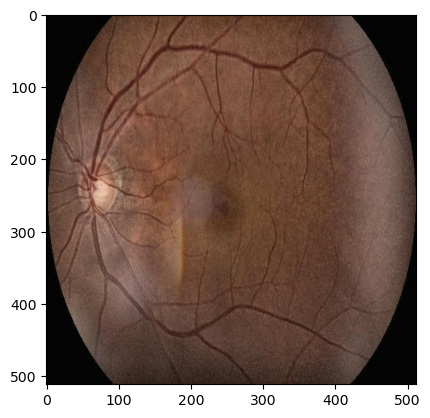

In [8]:
for image, label in val.take(6):
  print(image.shape)
  plt.imshow(image.numpy())
  print('label: ', CLASS_NAMES[np.nonzero(label.numpy()==1)[0][0]], label.numpy())

In [9]:
def randomly_augment(image,label):
#   image = tf.image.random_flip_left_right(image)
  #image = tf.image.central_crop(image, central_fraction=0.9)
#   image = tf.image.resize_with_pad(image, IMG_HEIGHT, IMG_WIDTH, method='bilinear', antialias=False)
#   image=tf.image.rgb_to_grayscale(image)
  
  image= tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH], method='bilinear', preserve_aspect_ratio=True)
  image=tf.image.per_image_standardization(image)
#   image=tf.image.per_image_standardization(image)
#   image=image/ 255.0
  return image, label

def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  ds = ds.shuffle(buffer_size=shuffle_buffer_size, reshuffle_each_iteration=False)
  ds = ds.map(randomly_augment, num_parallel_calls=AUTOTUNE)
  ds = ds.repeat()
  ds = ds.batch(BATCH_SIZE, drop_remainder=True)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

def prepare_for_testing(ds, cache=True):
  #caches the dataset in memory or on disk, which can speed up subsequent reads.
  ds = ds.cache()
  ds = ds.map(randomly_augment, num_parallel_calls=AUTOTUNE)
  #batches the dataset into batches of size 32, dropping the last batch if it is smaller than 32.
  ds = ds.batch(BATCH_SIZE, drop_remainder=True) 
  #repeats the dataset indefinitely, so that it can be used for multiple epochs during training or evaluation.
#   ds = ds.repeat()

  return ds
final_train_ds = prepare_for_training(train,cache=True)
final_val_ds = prepare_for_testing(val,cache=True)

In [10]:
for image, label in final_val_ds.take(6):
  print(image.shape)
#   plt.imshow(image.numpy())
#   print('label: ', CLASS_NAMES[np.nonzero(label.numpy()==1)[0][0]], label.numpy())

(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)


In [11]:
def get_model():
#     input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

    
    # Create a Convolutional layer with no padding
    model = tf.keras.Sequential()
    model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', padding='valid', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2),padding="valid"))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2),padding="valid"))
    model.add(tf.keras.layers.Dropout(0.5,))
    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5,))
#     model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=8, activation='sigmoid'))



    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return model



In [12]:
model=get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 223, 223, 32)      416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 111, 111, 128)     36992     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 128)      0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 55, 55, 128)       0         
                                                                 
 flatten (Flatten)           (None, 387200)            0

In [13]:
from keras.callbacks import ModelCheckpoint

# Define the file name for saving the best weights
best_weights_filepath = "/kaggle/working/weights_best.h5"

# Define the ModelCheckpoint callback for saving the best weights
best_checkpoint = ModelCheckpoint(best_weights_filepath,
                                  monitor='val_accuracy',
                                  verbose=1,
                                  save_best_only=True,
                                  mode='max')

best_checkpoint_loss = ModelCheckpoint("/kaggle/working/weights_best_loss.h5",
                                  monitor='val_loss',
                                  verbose=1,
                                  save_best_only=True,
                                  mode='min')

# Define the file name for saving the last weights
last_weights_filepath = "/kaggle/working/weights_last.h5"

# Define the ModelCheckpoint callback for saving the last weights
last_checkpoint = ModelCheckpoint(last_weights_filepath,
                                  save_weights_only=True,
                                  save_freq=(717*32)//BATCH_SIZE)

tb_callback=tf.keras.callbacks.TensorBoard(log_dir="/kaggle/working/logs_CNN/Original/",histogram_freq=1)

In [14]:
history=model.fit(final_train_ds.repeat(),
                    #batch_size=32,
                    epochs=50,
                    steps_per_epoch = 717, #train_elements/batch_size
                    validation_data=final_val_ds.repeat(),
                    validation_steps = 41,
                    callbacks=[best_checkpoint_loss],
#                     use_multiprocessing=True,
                    #class_weight=class_weight
                    )


Epoch 1/50


2023-03-28 06:15:04.723522: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


717/717 [==============================] - ETA: 0s - loss: 0.4019 - accuracy: 0.2833 - precision: 0.4785 - recall: 0.0973
Epoch 1: val_loss improved from inf to 0.32755, saving model to /kaggle/working/weights_best_loss.h5
717/717 [==============================] - 179s 220ms/step - loss: 0.4019 - accuracy: 0.2833 - precision: 0.4785 - recall: 0.0973 - val_loss: 0.3276 - val_accuracy: 0.3628 - val_precision: 0.7368 - val_recall: 0.0605
Epoch 2/50
717/717 [==============================] - ETA: 0s - loss: 0.3016 - accuracy: 0.4337 - precision: 0.7506 - recall: 0.2094
Epoch 2: val_loss improved from 0.32755 to 0.29278, saving model to /kaggle/working/weights_best_loss.h5
717/717 [==============================] - 148s 206ms/step - loss: 0.3016 - accuracy: 0.4337 - precision: 0.7506 - recall: 0.2094 - val_loss: 0.2928 - val_accuracy: 0.4588 - val_precision: 0.7548 - val_recall: 0.0843
Epoch 3/50
717/717 [==============================] - ETA: 0s - loss: 0.2759 - accuracy: 0.4842 - precisi

In [16]:
model.save("/kaggle/working/weights_last.h5")

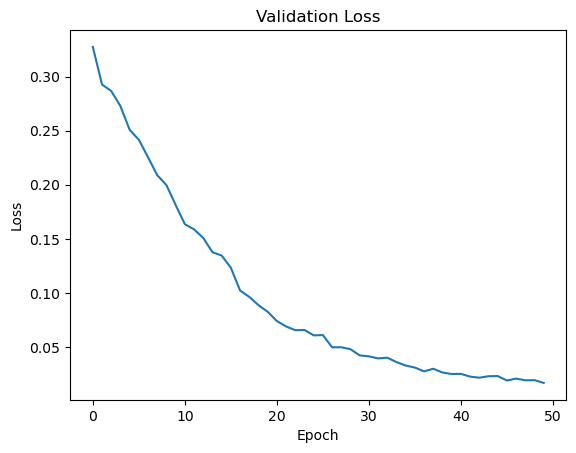

In [17]:
# Plot the validation loss
val_loss = history.history['val_loss']
plt.plot(val_loss)
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [18]:
import pickle
with open('history.pkl', 'wb') as file:
    pickle.dump(history.history, file)
# with open('history.json', 'w') as file:
#     json.dump(history_cnn.history, file)
df = pd.DataFrame(history.history)
df.to_csv('history.csv', index=False)
np.save('history.npy', history.history)

In [20]:
from keras.models import load_model
loaded_model =load_model("/kaggle/working/weights_best_loss.h5")
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 223, 223, 32)      416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 111, 111, 128)     36992     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 128)      0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 55, 55, 128)       0         
                                                                 
 flatten (Flatten)           (None, 387200)            0

In [22]:
[loss,accuracy,precision,recall]=loaded_model.evaluate(final_val_ds,steps=31)
print("Accuracy: ",accuracy*100)

31/31 [==============================] - 1s 34ms/step - loss: 0.0179 - accuracy: 0.9698 - precision: 0.9990 - recall: 0.9716
Accuracy:  96.97580933570862
